# Amazon food review dataset apply Logistic regression

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews


# Objective
1. Try predicting review using SVM grid and random search gamma and c
2. Get lambda 1 2(L1 and L2) using grid search and random search CV 
3. For L1 regularization try increasing lambda and see error. Get non zero element in w
4. Get features importance check for multicolinearity by adding small value
5. Plot accuracy and hyperparameter

# Import data and libraries
 

In [1]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\suman\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Data preprocessing

In [2]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [38]:
#take only 50000 data
print(sorted_data['Score'].value_counts())
#clean_data=sorted_data.sample(frac=1).groupby('Score').head(10000)
#take stratified sampling i.e. positive and negative reviews are proportionate to raw data
_ , clean_data = train_test_split(sorted_data, test_size = 50000, stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()

positive    307063
negative     57110
Name: Score, dtype: int64


positive    42159
negative     7841
Name: Score, dtype: int64

In [39]:
# Clean html tag and punctuation

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

In [40]:
i=0
str1=' '
mystop={'of','four','one','would'}
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    #change later
    #sent=sent[:20]
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop) & (cleaned_words.lower() not in mystop)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    

In [41]:
clean_data['CleanedText']=final_string
#store for future use
#conn = sqlite3.connect('clean_data.sqlite')
#c=conn.cursor()
#conn.text_factory = str
#clean_data.to_sql('Reviews1', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
#con = sqlite3.connect('clean_data.sqlite') 
#clean_data = pd.read_sql_query("""SELECT * FROM Reviews1 WHERE Score != 3""", con) 
#clean_data['CleanedText'].sample(15)
clean_data.shape
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data['CleanedText'].sample(2)

286076    b'pleasant surpris fresh tast orang bar realli...
171848    b'best product make bread bread machin everyth...
Name: CleanedText, dtype: object

# Create BOW and try grid search for logistic regreession with penalty l1 and l2

In [42]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(clean_data['CleanedText'].values)
print(final_counts.get_shape())
print(type(final_counts))
#print(final_counts[[1]])
print("new")
#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

(50000, 27310)
<class 'scipy.sparse.csr.csr_matrix'>
new


In [43]:
from sklearn.preprocessing import StandardScaler
x=final_counts
y =clean_data['Score']


#Standarize the features
#below not working
#sc = StandardScaler(with_mean=False)
# this is sparse matrix so standarization is required differently
from sklearn.preprocessing import normalize
x = normalize(x, norm='l1', axis=0)


#sc = StandardScaler()
#x = sc.fit_transform(x)
print(x.get_shape())
print(type(x))
#print(x[[1]])


n=x.shape[0]
n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]

#y should be changed to binary

from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(y, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y=encoded_labels

y_test=y[0:n1]
y_train=y[n1:n+1]


X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
#print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

(50000, 27310)
<class 'scipy.sparse.csc.csc_matrix'>
size of X_train, X_test, y_train , y_test  (35000, 27310) (15000, 27310) (35000,) (15000,)


In [44]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve

# Use grid search for L2
C=[10**-3, 10**-2, 10**-1, 1,10]

#param_range=C;

#c1=np.arrange(1, 250, 20)
penalty=['l1', 'l2']

tuned_parameters=dict(penalty=penalty,C=C)

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)

print('Best parameters \n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
print(type(X_train),type(y_train))


Best parameters 
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
<class 'scipy.sparse.csc.csc_matrix'> <class 'numpy.ndarray'>


In [45]:
#build model with best parameter
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)

aa=pd.DataFrame({'type':['Grid search BOW'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
#print(aa)

# Print coefficients
# check no of parameter
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
#print(model.coef_[0],model.coef_[8])
#print(model.coef_)
#print(model.C,model.penalty)

Count of non zero element in coefficient 4938
Model train and test score C and penalty 0.911971428571 0.8382 10 l1


# Apply Random search

In [46]:
# Random search 
from sklearn.model_selection import RandomizedSearchCV

#tuned_parameters = [{'penalty' : ['l1', 'l2']},

C=[10**-4, 10**-2, 10**0, 10**2, 10**4]
penalty=['l1', 'l2']

tuned_parameters=dict(C=C, penalty=penalty)

#Using random search
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

model.fit(X_train, y_train)


print('Model best extimator \n',model.best_estimator_)
#print(model.score(X_test, y_test))

optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty

# create model with the best parameter from random search

model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)


# Print coefficients
# check no of parameter
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
bb=pd.DataFrame({'type':['Random search BOW'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
print(aa)

Model best extimator 
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 12072
Model train and test score C and penalty 0.968942857143 0.863933333333 100 l1
     C penalty  test_score  train_score               type
0   10      l1    0.838200     0.911971    Grid search BOW
0  100      l1    0.863933     0.968943  Random search BOW


# Try increasing lambda for L1 and see error and sparcity(non 0 element of w)

In [47]:
for i in [.001,.01,.1,1,10,100,1000,10000]:
  model = LogisticRegression(C=i,penalty='l1')
  model.fit(X_train, y_train)
  w = model.coef_

  print('Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy\n',i,np.count_nonzero(w),np.shape(w),model.score(X_train, y_train),model.score(X_test, y_test))
  #print('model score',model.score(X_test,y_test))

#print(w)


Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 0.001 0 (1, 27310) 0.851142857143 0.8246
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 0.01 0 (1, 27310) 0.851142857143 0.8246
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 0.1 0 (1, 27310) 0.851142857143 0.8246
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 1 0 (1, 27310) 0.851142857143 0.8246
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 10 4967 (1, 27310) 0.912714285714 0.838333333333
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 100 12065 (1, 27310) 0.968942857143 0.863933333333
Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy
 1000 11175 (1, 27310) 0.99222

So We can see as C decreases i.e. lambda increases more coefficients are getting 0 and  test accuracy increases when C too low accuracy decreases again if C is too low
# See top features using the weights

In [48]:
#print(model.coef_[1])
coefs = np.abs(model.coef_[0])
indices = np.argsort(coefs)[::-1]
#print(indices)
#print(count_vect.get_feature_names())

In [49]:
#create optimum model
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)


def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    #negative words are sorted with -ve
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    top_pos_fet=[]
    top_neg_fet=[]
    for coef, feat in topn_class1:
        print (class_labels[0], coef, feat)
        top_pos_fet.append(feat)

    print("\n")

    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)
        top_neg_fet.append(feat)
        
    return top_pos_fet,top_neg_fet 

print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(count_vect, model)

Top 10 words for both review 0 negative 1 positive with weights

0 -3077.2179721 disappoint
0 -1652.9975165 bad
0 -1213.63238997 thought
0 -1204.21845854 aw
0 -1146.3880296 terribl
0 -1128.70382556 money
0 -1121.39663435 horribl
0 -1077.38007019 worst
0 -1042.36105164 return
0 -1027.37078209 unfortun


1 5440.0 great
1 5017.96549989 love
1 4804.31139217 best
1 3362.15637588 perfect
1 3353.73812941 delici
1 1974.53175044 excel
1 1579.62281001 tasti
1 1563.1358183 favorit
1 1259.92774809 nice
1 1196.04334525 keep


# Check multicolinearity with perbutation test by adding small noise to sparse matrix
The noise is with mean 0 and sd=.0001

In [50]:
# Check VIF score of the above selected variables
#vif = pd.DataFrame()
#print(x.toarray().shape,x.shape[1])
#vif["VIF Factor"] = [variance_inflation_factor(x.toarray(), i) for i in range(x.shape[1])]
#vif["features"] = count_vect.get_feature_names()
#print(vif)
#for i in top_pos_fet:
#  print(vif[(vif[["features"]]==i).values])

#for i in top_neg_fet:
#  print(vif[(vif[["features"]]==i).values])

# creating VIF is giving a lot of inf

In [51]:
#refer https://medium.com/@dhwajraj/learning-python-regression-analysis-part-9-tests-and-validity-for-regression-models-78dcd5cde3a1
# to find colinearity by eigen value
#corr=np.corrcoef(x,rowvar=0)
#W,V=np.linalg.eig(corr)
#If at least one of the eigen values of the correlation matrix is close to zero then we can say that multicollinearity exists in the dataset

#The eigen values at index 3,4 and 5 are close to zero. There corresponding eigen vectors are:

#in the output produced above, column index 2 and 3 have near zero values in all three eigen vectors so we can say that columns 0,1,4 and 5 are strongly correlated with each other so any one of them would be sufficient to capture the essence of the other three columns.




In [52]:
from scipy import *
import random
from scipy.sparse import *
    
#print(X_train)
#print(X_train.data.shape[0])
#X_train.todense()
#print("hi")
#X_train.data+=X_train
#X_train.todense()
X_train.data += np.random.normal(0,.0001,X_train.data.shape[0])
#print(X_train)

# Create model after adding some noise and check weights
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)

print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(count_vect, model)

Top 10 words for both review 0 negative 1 positive with weights

0 -3077.10091129 disappoint
0 -1624.83929695 bad
0 -1230.52805736 aw
0 -1183.08374384 terribl
0 -1132.23714539 horribl
0 -1130.43471644 money
0 -1078.19914821 return
0 -1077.81626203 worst
0 -1056.94920513 unfortun
0 -1053.09605742 noth


1 3400.0 best
1 3372.80909943 great
1 3140.52489553 delici
1 3102.76664556 perfect
1 1922.60193055 excel
1 1871.4953013 love
1 1580.31088605 good
1 1463.46979206 favorit
1 1452.09431946 tasti
1 1079.79385601 easi


So we can see after adding noise the weights of top 20 words are almost same as earlier, so multicolinearity doesnot exist

# Plot traing and CV error with C and l1 penalty

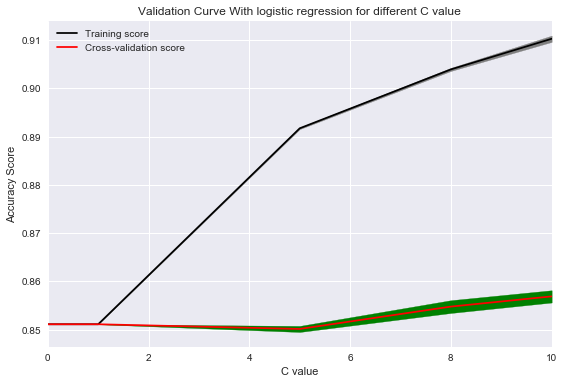

In [53]:
#create plot for training and test validation
# Calculate accuracy on training and test set using range of parameter values
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]


train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")

#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")

plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Plot traing and CV error with C and l2 penalty

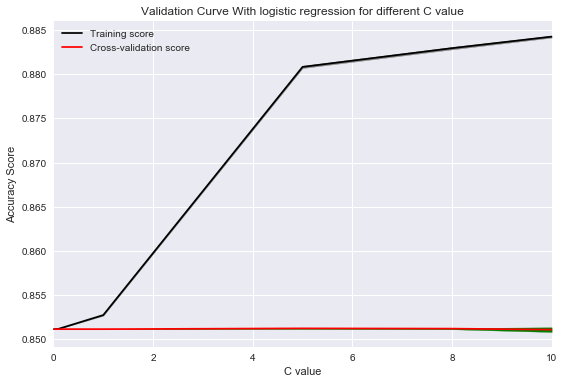

In [54]:
#create plot for training and test validation
# Calculate accuracy on training and test set using range of parameter values
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]


train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")

#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")

plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


In [55]:
aa

,C,penalty,test_score,train_score,type
0,10,l1,0.838200,0.911971,Grid search BOW
0,100,l1,0.863933,0.968943,Random search BOW


In [56]:
aa

,C,penalty,test_score,train_score,type
0,10,l1,0.838200,0.911971,Grid search BOW
0,100,l1,0.863933,0.968943,Random search BOW


# TFIDF

size of X_train, X_test, y_train , y_test  (35000, 27310) (15000, 27310) (35000,) (15000,)
Best parameters 
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 5272
Model train and test score C and penalty 0.921028571429 0.845133333333 10 l1
Model best extimator 
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 13833
Model train and test score C and penalty 0.975514285714 0.862733333333 100 l1
     C penalty  test_score  train_score                 type
0   10      l1    0.838200    

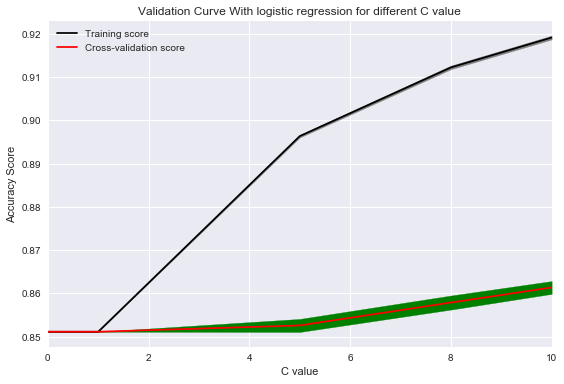

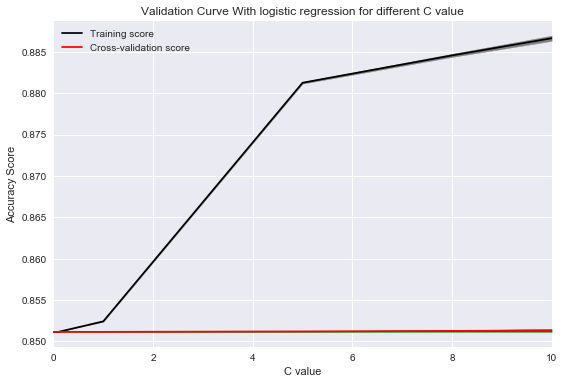

In [57]:
# Create BOW and try grid search for logistic regreession with penalty l1 and l2
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
from sklearn.preprocessing import StandardScaler
x=final_counts
y =clean_data['Score']
from sklearn.preprocessing import normalize
x = normalize(x, norm='l1', axis=0)
n=x.shape[0]
n1=int(n*.3)
from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(y, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y=encoded_labels
y_test=y[0:n1]
y_train=y[n1:n+1]
X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
C=[10**-3, 10**-2, 10**-1, 1,10]
penalty=['l1', 'l2']
tuned_parameters=dict(penalty=penalty,C=C)
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
#build model with best parameter
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
bb=pd.DataFrame({'type':['Grid search TFIDF'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
# Random search 
from sklearn.model_selection import RandomizedSearchCV
C=[10**-4, 10**-2, 10**0, 10**2, 10**4]
penalty=['l1', 'l2']
tuned_parameters=dict(C=C, penalty=penalty)
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Model best extimator \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
bb=pd.DataFrame({'type':['Random search TFIDF'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
print(aa)
#try increasing lambda
for i in [.001,.01,.1,1,10,100,1000,10000]:
  model = LogisticRegression(C=i,penalty='l1')
  model.fit(X_train, y_train)
  w = model.coef_
  print('Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy\n',i,np.count_nonzero(w),np.shape(w),model.score(X_train, y_train),model.score(X_test, y_test))
#See top features
coefs = np.abs(model.coef_[0])
indices = np.argsort(coefs)[::-1]
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(tf_idf_vect , model)
#Check multicolinearity
from scipy import *
import random
from scipy.sparse import *
X_train.data += np.random.normal(0,.0001,X_train.data.shape[0])
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(tf_idf_vect, model)
#plot training and cv error with c and l1
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()
#plot training and cv with c and l2
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# AVG W2V

size of X_train, X_test, y_train , y_test  (35000, 50) (15000, 50) (35000,) (15000,)
Best parameters 
 LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 0
Model train and test score C and penalty 0.851142857143 0.8246 0.001 l1
Model best extimator 
 LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 50
Model train and test score C and penalty 0.892885714286 0.8832 10000 l1
           C penalty  test_score  train_score                  type
0     10.000      l1    0.838200     0.91

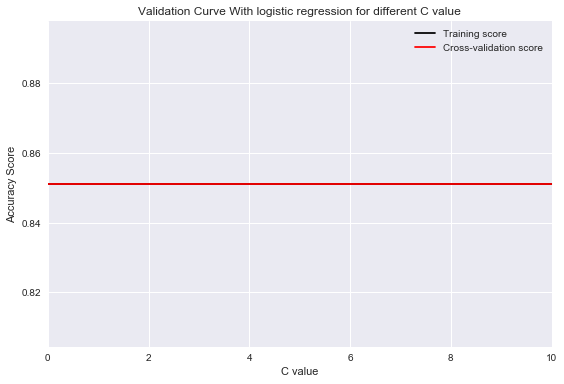

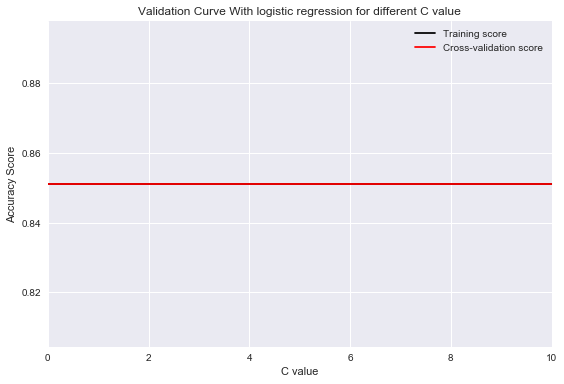

In [58]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
i=0
#create a list of list to be used in W2V 
list_of_sent=[]
for sent in clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)  

#Sent_vectors ready for tsne   



x=sent_vectors
y =clean_data['Score']
from sklearn.preprocessing import normalize
x = normalize(x, norm='l1', axis=0)
n=x.shape[0]
n1=int(n*.3)
from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(y, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y=encoded_labels
y_test=y[0:n1]
y_train=y[n1:n+1]
X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
C=[10**-3, 10**-2, 10**-1, 1,10]
penalty=['l1', 'l2']
tuned_parameters=dict(penalty=penalty,C=C)
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
#build model with best parameter
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
bb=pd.DataFrame({'type':['Grid search AVGW2V'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
# Random search 
from sklearn.model_selection import RandomizedSearchCV
C=[10**-4, 10**-2, 10**0, 10**2, 10**4]
penalty=['l1', 'l2']
tuned_parameters=dict(C=C, penalty=penalty)
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Model best extimator \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
bb=pd.DataFrame({'type':['Random search AVGW2V'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
print(aa)
#try increasing lambda
for i in [.001,.01,.1,1,10,100,1000,10000]:
  model = LogisticRegression(C=i,penalty='l1')
  model.fit(X_train, y_train)
  w = model.coef_
  print('Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy\n',i,np.count_nonzero(w),np.shape(w),model.score(X_train, y_train),model.score(X_test, y_test))
#See top features
coefs = np.abs(model.coef_[0])
indices = np.argsort(coefs)[::-1]
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
#print("Top 10 words for both review 0 negative 1 positive with weights\n")
#top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(sent_vectors.toarray() , model)
#Check multicolinearity
from scipy import *
import random
from scipy.sparse import *
#X_train.data += np.random.normal(0,.0001,X_train.data.shape[0])
#model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
#model.fit(X_train, y_train)
#print("Top 10 words for both review 0 negative 1 positive with weights\n")
#top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(sent_vectors.toarray(), model)
#plot training and cv error with c and l1
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()
#plot training and cv with c and l2
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# TFIDF AVGW2V

size of X_train, X_test, y_train , y_test  (35000, 50) (15000, 50) (35000,) (15000,)
Best parameters 
 LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 0
Model train and test score C and penalty 0.851142857143 0.8246 0.001 l1
Model best extimator 
 LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Count of non zero element in coefficient 50
Model train and test score C and penalty 0.880971428571 0.869 10000 l1
           C penalty  test_score  train_score                       type
0     10.000      l1    0.838200     

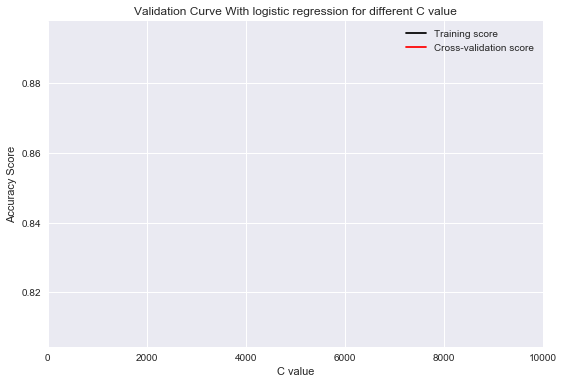

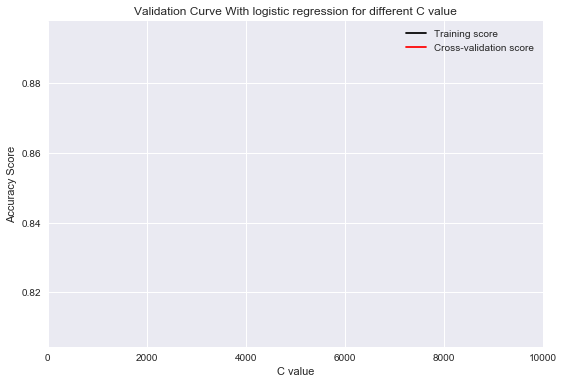

In [61]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
#tfidf_sent_vectors.


x=tfidf_sent_vectors
y =clean_data['Score']
from sklearn.preprocessing import normalize
x = normalize(x, norm='l1', axis=0)
n=x.shape[0]
n1=int(n*.3)
from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(y, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y=encoded_labels
y_test=y[0:n1]
y_train=y[n1:n+1]
X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
C=[10**-3, 10**-2, 10**-1, 1,10]
penalty=['l1', 'l2']
tuned_parameters=dict(penalty=penalty,C=C)
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
#build model with best parameter
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
bb=pd.DataFrame({'type':['Grid search AVGW2VTFIDF'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
# Random search 
from sklearn.model_selection import RandomizedSearchCV
C=[10**-4, 10**-2, 10**0, 10**2, 10**4]
penalty=['l1', 'l2']
tuned_parameters=dict(C=C, penalty=penalty)
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)
model.fit(X_train, y_train)
print('Model best extimator \n',model.best_estimator_)
optimumc=model.best_estimator_.C
optimumpenalty=model.best_estimator_.penalty
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
w = model.coef_
print('Count of non zero element in coefficient',np.count_nonzero(w))
print('Model train and test score C and penalty',model.score(X_train,y_train),model.score(X_test,y_test),model.C,model.penalty)
bb=pd.DataFrame({'type':['Random search AVGW2VTFIDF'],'train_score':[model.score(X_train,y_train)],'test_score':[model.score(X_test,y_test)],'C':[model.C],'penalty':[model.penalty]})
aa=aa.append(bb)
print(aa)
#try increasing lambda
for i in [.001,.01,.1,1,10,100,1000,10000]:
  model = LogisticRegression(C=i,penalty='l1')
  model.fit(X_train, y_train)
  w = model.coef_
  print('Count of non zero, total element (l1), coefficient ( C or 1/lambda),train accuracy and test accuracy\n',i,np.count_nonzero(w),np.shape(w),model.score(X_train, y_train),model.score(X_test, y_test))
#See top features
coefs = np.abs(model.coef_[0])
indices = np.argsort(coefs)[::-1]
model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
model.fit(X_train, y_train)
print("Top 10 words for both review 0 negative 1 positive with weights\n")
top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(tf_idf_vect , model)
#Check multicolinearity
from scipy import *
import random
from scipy.sparse import *
#X_train.data += np.random.normal(0,.0001,X_train.data.shape[0])
#model = LogisticRegression(C=optimumc,penalty=optimumpenalty)
#model.fit(X_train, y_train)
#print("Top 10 words for both review 0 negative 1 positive with weights\n")
#top_pos_fet,top_neg_fet=most_informative_feature_for_binary_classification(tf_idf_vect, model)
#plot training and cv error with c and l1
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10000)
plt.tight_layout()
plt.legend(loc="best")
plt.show()
#plot training and cv with c and l2
C=[10**-2, 10**-1, 1,5,8,10]
param_range=[10**-2, 10**-1, 1,5,8,10]
train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With logistic regression for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.0001,10000)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Conclusion

1. Increasing C
We can see as C decreases i.e. lambda increases more coefficients are getting 0 and test accuracy increases when C too low accuracy decreases again

3. Multicolinearity
After adding some noise on data the weights are almost same so multicolinearity doesnot exist

4. The most important words for positive and negatives are making sense
Accuracy scores are below


In [64]:
aa

,C,penalty,test_score,train_score,type
0,10.000,l1,0.838200,0.911971,Grid search BOW
0,100.000,l1,0.863933,0.968943,Random search BOW
0,10.000,l1,0.845133,0.921029,Grid search TFIDF
0,100.000,l1,0.862733,0.975514,Random search TFIDF
0,0.001,l1,0.824600,0.851143,Grid search AVGW2V
0,10000.000,l1,0.883200,0.892886,Random search AVGW2V
0,0.001,l1,0.824600,0.851143,Grid search AVGW2VTFIDF
0,10000.000,l1,0.868867,0.880971,Random search AVGW2VTFIDF
